!['instacart basket'](./images/ipad_grocery.png)

# Instacart Market Basket Analysis : Exploratory Data Analysis &  Modeling
__________________________________________________________________________________________________________________
**Author:** [Brandon Menendez](http://linkedin.com/in/brandon-menendez/)

In [77]:
# Importing relevant libraries 

import numpy as np
import scipy
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix, confusion_matrix,precision_score, recall_score,\
accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import warnings
warnings.filterwarnings("ignore", category=Warning)

## Business Problem
__________________________________________________________________________________________________________________

>"*Online grocery shopping in the U.S. trails that of other e-commerce categories in large part because our grocery shopping habits are so deeply ingrained, and online grocery retailers haven't yet convinced customers that grocery shopping online can be a better experience*" <br> <br>
> -Stephen Caine, Bain & Company




When the COVID-19 pandemic hit, many Americans opted to stay in their homes and order groceries online rather than go in person to their local grocery store. A [nationally representative survey](https://academic.oup.com/cdn/article/5/Supplement_2/231/6293076?login=false) found that **34%** of households reported grocery shopping online more since the beginning of the pandemic and **60%** of these households planned to continue shopping online after the pandemic ends. 

This sudden increase in customer's shopping online was a major tailwind for online grocers. But just as important as customer acquisition is for these companies, so is customer retention. Like the classic saying goes, "Old habits die hard" and online grocers need to ensure they are utilizing their technology to provide a more convenient shopping experience in order to hold on to those customers deciding to shop online rather than in-store. There are three major tools that all online grocers can utilize in an attempt to retain customers gained during the pandemic:

1. Merchandising
2. Recommendations
3. Coupons & Promotions

Instacart is a grocery ordering and delivery app, which has over 500 million products available across 40,000 grocery stores in the United States & Canada. Instacart provides a convenient customer experience, which is largely focused around product recommendations based on past purchases. In addition to recommendaiton widgets  (Add to Cart, Frequently bought together etc), Instacart also works with retailers to provide targeted promotions and coupons to its customers. 

**Objective:** <br>
Using over 3M rows of customer order data provided by Instacart, I will be performing a market basket analysis and implement predictive modeling  to:

1. Identify frequent items sets and association rules to better inform merchandising, customer recommendations and promotional stategies for Instacart <br>
2. Predict ahead of time which items will be re-ordered by a particular customer

Using the insights gained from this analysis, I will provide recommendations for how Instacart can improve their merchandising, recommendation and promotional strategy in an effort to maintain customers for the long-term.

## Data Understanding
__________________________________________________________________________________________________________________

The data for this project was released by Instacart in 2017 as part of their [3 Million Instacart Order Competition](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2).

The provided anonymized dataset contains a sample of over 3 million customer orders, inclusive of over 49 thousand unique products and 200 thousand unique customers. For each user, Instacart provided between 4 and 100 of their orders, with the sequence of products purchased in each order. They also provide the week and hour of day the order was placed, a relative measure of time between orders and product attributes.

For this analysis I will be utilizing the following tables:
   - **orders** - Indicates which evaluation set an order belongs too  
   - **orders_prior** - Contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product
   - **products** - Provides additional information about the products ordered, including product name, department, and aisle
   - **aisles** - Contains attributes about aisles
   - **departments** - Contains attributes about departments 

In [2]:
# Reading  in  data

orders = pd.read_csv('orders.csv') 
orders_train = pd.read_csv('order_products__train.csv')
orders_prior = pd.read_csv('order_products__prior.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
depts = pd.read_csv('departments.csv')

### Exploring 'orders.csv'

In [3]:
# orders shape 

orders.shape

(206262, 7)

In [4]:
# visualizing orders  

orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1.0,prior,1.0,2.0,8.0,NaN
1,2398795,1.0,prior,2.0,3.0,7.0,15.0
2,473747,1.0,prior,3.0,3.0,12.0,21.0
3,2254736,1.0,prior,4.0,4.0,7.0,29.0
4,431534,1.0,prior,5.0,4.0,15.0,28.0


In [5]:
# checking for nulls 

orders.isna().sum()

order_id                      0
user_id                       1
eval_set                      1
order_number                  1
order_dow                     1
order_hour_of_day             1
days_since_prior_order    12468
dtype: int64

In [6]:
# checking distribution between eval sets 

orders['eval_set'].value_counts()

prior    193795
train      7951
test       4515
Name: eval_set, dtype: int64

### Exploring 'orders_prior.csv'

In [7]:
# orders_prior shape 

orders_prior.shape

(396560, 4)

In [8]:
# visualizing orders_prior

orders_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120.0,1.0,1.0
1,2,28985.0,2.0,1.0
2,2,9327.0,3.0,0.0
3,2,45918.0,4.0,1.0
4,2,30035.0,5.0,0.0


In [9]:
# checking for nulls 

orders_prior.isna().sum()

order_id             0
product_id           1
add_to_cart_order    1
reordered            1
dtype: int64

### Exploring 'products.csv' 

In [10]:
# products shape 

products.shape

(49688, 4)

In [11]:
# visualizing products

products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### Exploring 'aisles.csv'

In [12]:
# aisles shape

aisles.shape

(134, 2)

In [13]:
# visualizing aisles

aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### Exploring 'depts.csv'

In [14]:
# depts shape

depts.shape

(21, 2)

In [15]:
# visualizing depts

depts.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


## Data Exploration
__________________________________________________________________________________________________________________
There are many features included in this data that will aid in the predictive models implemented later in the notebook. Additionally, these features can provide important insights for Instacart about customer order behavior. In this section, I will be analyzing product and user trends, as well as engineering additional features for modeling.

In [16]:
# Merging  products + aisles + department into one df 

product_df = products.merge(aisles, how='left', left_on = 'aisle_id', right_on = 'aisle_id')
product_df = product_df.merge(depts, how='left', left_on='department_id', right_on='department_id')

# Dropping duplicative columns 

product_df.drop(columns=['aisle_id','department_id'],inplace=True)

In [17]:
# Inner join orders and orders_prior to isolate only prior orders

orders_products = orders.merge(orders_prior,on='order_id',how='inner')

In [18]:
# getting descriptive statistics for orders_products 

orders_products.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
count,23490.000000,23482.000000,23482.000000,23482.000000,23482.000000,21966.000000,23490.000000,23490.000000,23490.000000
mean,20650.324904,6386.120518,17.351887,2.704114,13.451282,11.246335,25552.266071,8.279693,0.601575
std,12258.006095,3578.092384,17.319659,2.064958,4.370139,8.773841,14093.845114,7.166314,0.489584
min,8.000000,7.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,9921.000000,3417.000000,5.000000,1.000000,10.000000,5.000000,13380.000000,3.000000,0.000000
50%,20650.000000,6405.000000,11.000000,3.000000,13.000000,8.000000,25246.000000,6.000000,1.000000
75%,31414.000000,9372.000000,25.000000,5.000000,17.000000,15.000000,37690.000000,11.000000,1.000000
max,41904.000000,12461.000000,99.000000,6.000000,23.000000,30.000000,49683.000000,60.000000,1.000000


In [19]:
# merging orders_products with products

orders_products =  orders_products.merge(product_df,how='left',left_on='product_id',right_on='product_id')

In [20]:
orders_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23490 entries, 0 to 23489
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                23490 non-null  int64  
 1   user_id                 23482 non-null  float64
 2   eval_set                23482 non-null  object 
 3   order_number            23482 non-null  float64
 4   order_dow               23482 non-null  float64
 5   order_hour_of_day       23482 non-null  float64
 6   days_since_prior_order  21966 non-null  float64
 7   product_id              23490 non-null  float64
 8   add_to_cart_order       23490 non-null  float64
 9   reordered               23490 non-null  float64
 10  product_name            23490 non-null  object 
 11  aisle                   23490 non-null  object 
 12  department              23490 non-null  object 
dtypes: float64(8), int64(1), object(4)
memory usage: 2.5+ MB


In [21]:
orders_products.isna().sum()

order_id                     0
user_id                      8
eval_set                     8
order_number                 8
order_dow                    8
order_hour_of_day            8
days_since_prior_order    1524
product_id                   0
add_to_cart_order            0
reordered                    0
product_name                 0
aisle                        0
department                   0
dtype: int64

In [22]:
# Checking amount of unique order_ids and user_ids present in the prior df

unique_orders = orders_products['order_id'].nunique()
unique_users = orders_products['user_id'].nunique()

print(f"Orders: {unique_orders}, Users: {unique_users}")

Orders: 2374, Users: 2022


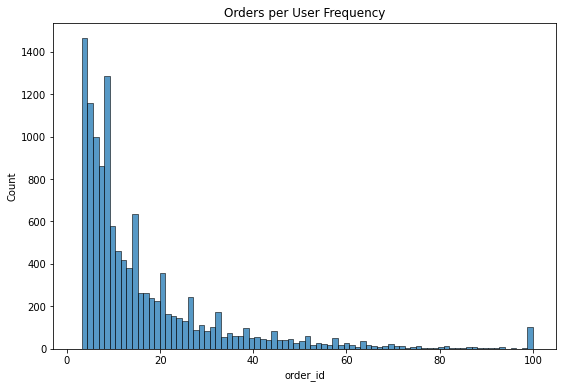

In [23]:
# How many orders are placed by each user?
fig, ax = plt.subplots(figsize=(9,6))

x = orders.groupby('user_id')['order_id'].count()

# sns.set_style('darkgrid')
sns.histplot(x=x)

ax.set_title('Orders per User Frequency');

**Observation:**
- We already know that the dataset contains between 4 and 100 orders per user
- The histogram shows that there are few customers who placed more than 60 orders, and the most any one customer has placed is 100.
- Most users orders fall between 0 and 20

In [24]:
# What is the frequency distribution of basket sizes?

print("Min items per order: " + str(x.min()))
print("Max items per order: " + str(x.max()))

Min items per order: 2
Max items per order: 100


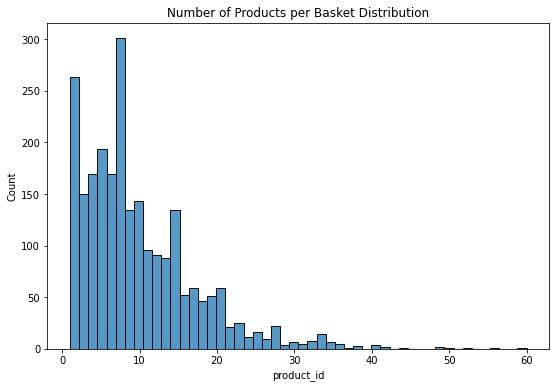

In [25]:
# Visualizing basekt size distribution

fig, ax = plt.subplots(figsize=(9,6))

x = orders_products.groupby('order_id')['product_id'].count()

sns.histplot(x=x)

ax.set_title('Number of Products per Basket Distribution');

In [26]:
# What is the target distribution?

orders_products['reordered'].value_counts()

1.0    14131
0.0     9359
Name: reordered, dtype: int64

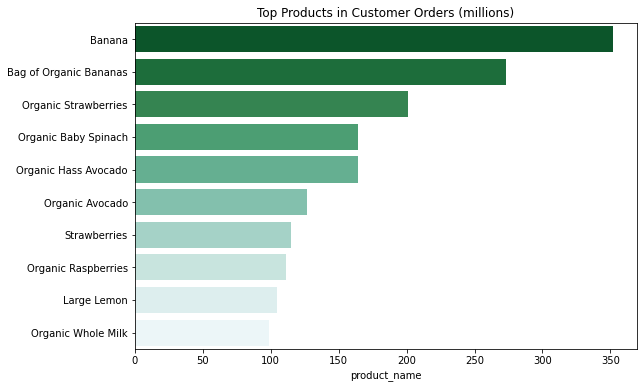

In [27]:
# What products are most commonly included in customers baskets?

fig, ax = plt.subplots(figsize=(9,6))

x = orders_products['product_name'].value_counts().head(10)
y = orders_products['product_name'].value_counts().head(10).index


sns.barplot(x=x, y=y,orient='h',palette ='BuGn_r')

ax.set_title('Top Products in Customer Orders (millions)');

**Observation:** 
- Banana's are the most frequently ordered product by Instacart users, taking up the top two spots
- Produce (specifically organic) are the most commonly ordered products, with Organic Whole Milk being the 10th most common

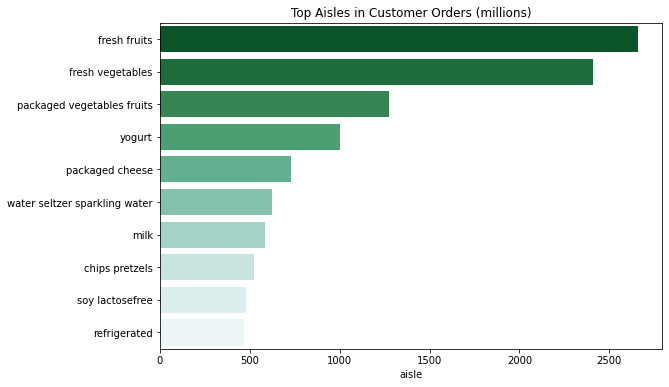

In [28]:
# Visualizing most ordered from aisles 

fig, ax = plt.subplots(figsize=(9,6))


x = orders_products['aisle'].value_counts().head(10)
y = orders_products['aisle'].value_counts().head(10).index

sns.barplot(x=x, y=y,orient='h',palette ='BuGn_r')

ax.set_title('Top Aisles in Customer Orders (millions)');

**Observation:** 
- Consistent with the top ordered products, the most ordered from departments are largely produce and dairy

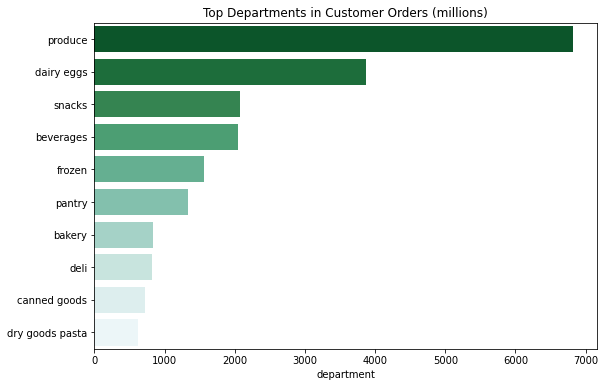

In [29]:
# Visualizing most ordered from departments 

fig, ax = plt.subplots(figsize=(9,6))

x = orders_products['department'].value_counts().head(10)
y = orders_products['department'].value_counts().head(10).index

sns.barplot(x=x, y=y,orient='h',palette ='BuGn_r')

ax.set_title('Top Departments in Customer Orders (millions)');

**Observation:** 
- There is a clear trend here: customers are buying produce and dairy products most frequently. Instacart should keep this in mind when merchandising products and identifying basket-builders for promotions.

In [30]:
# Percentage of reorders from priors df

orders_products['reordered'].sum()/orders_products.shape[0]

0.6015751383567476

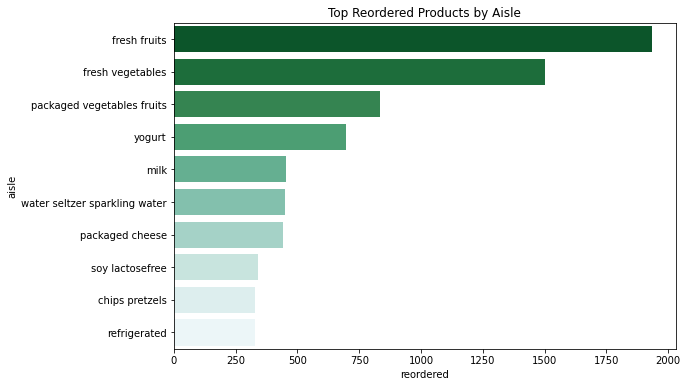

In [31]:
# Visualizing reorders by product by aisle 

fig, ax = plt.subplots(figsize=(9,6))

x = orders_products.groupby('aisle')['reordered'].sum().sort_values(ascending=False).head(10).index
y = orders_products.groupby('aisle')['reordered'].sum().sort_values(ascending=False).head(10)

ax.set_title('Top Reordered Products by Aisle')

sns.barplot(x=y, y=x,orient='h',palette ='BuGn_r');


**Obeservation:**
- There appears to be no difference in re-order trends between products. Let's move on to understanding user trends throughout the day and week

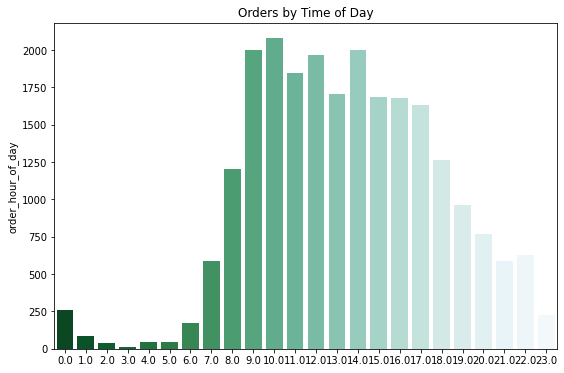

In [32]:
# Visualizing orders by time of day 

fig, ax = plt.subplots(figsize=(9,6))

x = orders_products['order_hour_of_day'].value_counts(sort=False).index
y = orders_products['order_hour_of_day'].value_counts(sort=False)

ax.set_title('Orders by Time of Day')

sns.barplot(x=x, y=y,orient='v',palette ='BuGn_r');


**Observation:** 
- Customers tend to order most frequently in the morning and early afternoon. This makes sense since most customers would want their orders to be delivered ahead of dinner time

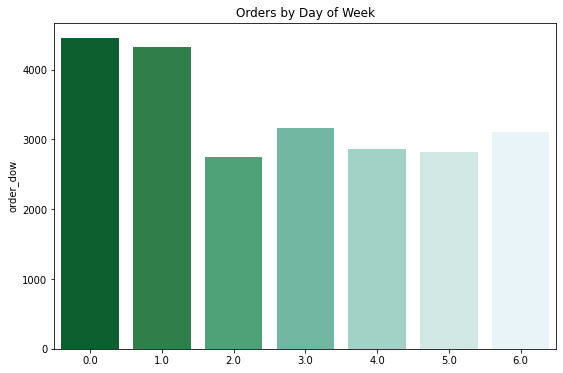

In [33]:
# Visualizing orders by day of the week 

fig, ax = plt.subplots(figsize=(9,6))

x = orders_products['order_dow'].value_counts(sort=False).index
y = orders_products['order_dow'].value_counts(sort=False)

ax.set_title('Orders by Day of Week')

sns.barplot(x=x, y=y,orient='v',palette ='BuGn_r');

**Observation:** 
- Customers tend to order most frequently in the beginning of the week (Sun-Tues), with a slight uptick over the weekend. This likely reflects customers stocking up on the groceries they need for the rest of the week.

## Feature Engineering
__________________________________________________________________________________________________________________
In order to aid in the modeling process further below in the notebook, I will be engineering features that describe customer behavior as it relates to product preferences and ordering behavior. <br>

**Product Features:**
   - *prd_order_frequency:*  Total orders of a product per user  
   - *prd_total_orders:*  Total orders of a product across all orders
   - *prd_total_reorders:*  Total reorders of a product across all orders
   - *prd_reorder_prob:*  Probability that a product will be re-ordered by a customer
   - *prd_reorder_times:*  Number of times a product has been re-ordered after the first order 
   - *prd_reorder_ratio:*  Ratio of reordered to total orders of a product <br>
   
**User Features:**
   - *total_user_orders:*  Total orders by user 
   - *user_reorders:*  Total reorders by user
   - *user_avg_bskt:*  Average basket size by user
   - *total_user_prod_orders* :  Total products ordered by a customer



### Product Features 

In [34]:
orders_products.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle,department
0,23391,7.0,prior,17.0,0.0,10.0,28.0,13198.0,1.0,1.0,85% Lean Ground Beef,meat counter,meat seafood
1,23391,7.0,prior,17.0,0.0,10.0,28.0,42803.0,2.0,1.0,Organic Apple Slices,fruit vegetable snacks,snacks
2,23391,7.0,prior,17.0,0.0,10.0,28.0,8277.0,3.0,1.0,Apple Honeycrisp Organic,fresh fruits,produce
3,23391,7.0,prior,17.0,0.0,10.0,28.0,37602.0,4.0,1.0,Mexican Coffee,coffee,beverages
4,23391,7.0,prior,17.0,0.0,10.0,28.0,40852.0,5.0,1.0,Lactose Free Fat Free Milk,soy lactosefree,dairy eggs


In [35]:
# Calculating product_order_frequency

orders_products['product_order_freq'] = orders_products.groupby(['user_id','product_id']).cumcount() + 1

In [36]:
# Calculating total orders by product 

group = orders_products.groupby('product_id')['product_id'].transform('count')

orders_products['prd_total_orders'] = group

In [37]:
# Calculating first_orders by product

orders_products['first_orders'] = (orders_products.assign(first = orders_products['product_order_freq']
                          .where(orders_products['product_order_freq'] == 1))
                          .groupby('product_id')['first']
                          .transform('sum'))

In [38]:
# Calculating second_orders by product

orders_products['second_orders'] = (orders_products.assign(second = orders_products['product_order_freq']
                          .where(orders_products['product_order_freq'] == 2))
                          .groupby('product_id')['second']
                          .transform('sum'))

In [39]:
# Calcuating total reorders by product 

group = orders_products.groupby('product_id')['reordered'].transform('sum')

orders_products['prd_total_reorders'] = group

In [40]:
# Calculating final product features 

orders_products['prd_reorder_prob'] = orders_products['second_orders']/orders_products['first_orders']
orders_products['prd_reorder_times'] = 1 + (orders_products['prd_total_reorders']/orders_products['first_orders'])
orders_products['prd_reorder_ratio'] = orders_products['prd_total_reorders']/orders_products['prd_total_orders']
orders_products.drop(columns=['first_orders','second_orders'],inplace=True)

In [41]:
# Updated table info with product features columns 

orders_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23490 entries, 0 to 23489
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                23490 non-null  int64  
 1   user_id                 23482 non-null  float64
 2   eval_set                23482 non-null  object 
 3   order_number            23482 non-null  float64
 4   order_dow               23482 non-null  float64
 5   order_hour_of_day       23482 non-null  float64
 6   days_since_prior_order  21966 non-null  float64
 7   product_id              23490 non-null  float64
 8   add_to_cart_order       23490 non-null  float64
 9   reordered               23490 non-null  float64
 10  product_name            23490 non-null  object 
 11  aisle                   23490 non-null  object 
 12  department              23490 non-null  object 
 13  product_order_freq      23490 non-null  int64  
 14  prd_total_orders        23490 non-null

### User Features

In [42]:
# Calculating total orders per user 

orders_products['total_user_orders'] = orders_products.groupby('user_id')['order_number'].transform('max')

In [43]:
# Calculating total reorders per user 

group = orders_products['reordered'].groupby(orders_products['user_id']).transform('sum')

orders_products['user_reorders'] = group 

In [44]:
# Calculating total products ordered by user 

group = orders_products['order_id'].groupby(orders_products['user_id']).transform('count')

orders_products['total_user_prod_orders'] = group

In [45]:
# Calculating re-order ratio by product user 

orders_products['user_reorder_ratio'] = orders_products['user_reorders']/orders_products['total_user_prod_orders']

In [46]:
# Calculating average basket size by user 

orders_products['user_avg_bskt'] = orders_products['total_user_prod_orders']/orders_products['total_user_orders']

In [47]:
# Updated table info with user features 

orders_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23490 entries, 0 to 23489
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                23490 non-null  int64  
 1   user_id                 23482 non-null  float64
 2   eval_set                23482 non-null  object 
 3   order_number            23482 non-null  float64
 4   order_dow               23482 non-null  float64
 5   order_hour_of_day       23482 non-null  float64
 6   days_since_prior_order  21966 non-null  float64
 7   product_id              23490 non-null  float64
 8   add_to_cart_order       23490 non-null  float64
 9   reordered               23490 non-null  float64
 10  product_name            23490 non-null  object 
 11  aisle                   23490 non-null  object 
 12  department              23490 non-null  object 
 13  product_order_freq      23490 non-null  int64  
 14  prd_total_orders        23490 non-null

## Modeling
__________________________________________________________________________________________________________________
In order to predict whether or not a customer will reorder a particular item, I will be using two classification models. The first model implemented is a binary LogisticRegression classification. This will be used to generate predictions for customer reorders. The second is an XGBoost model, which I will primarily use for Feature Importance understanding. Additionally, I implement a Grid Search for both models to optimize the hyperparameters used.

### Logistic Regression

In [48]:
# Dropping unnecessary columns ahead of modeling 

orders_model = orders_products.select_dtypes(exclude=['object'])

In [49]:
# Fill null values from days_since_prior_order with 0 

orders_model.fillna(0,inplace=True)

In [50]:
# Setting up target and features 

X = orders_model.drop(columns='reordered')
y = orders_model['reordered']

In [51]:
# Setting up train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.50,random_state=42)

In [52]:
# Scaling data for logreg model

log_scaler = StandardScaler()


# Fit and transform train, transform test

X_train_scaled = log_scaler.fit_transform(X_train)
X_test_scaled = log_scaler.transform(X_test)

In [53]:
# Instantiating model 

log_model = LogisticRegression(penalty='l2', 
                               C=2, 
                               class_weight='balanced', 
                               solver='lbfgs',
                               random_state=42) 

In [54]:
# Fit model on train 

log_model.fit(X_train_scaled,y_train)

LogisticRegression(C=2, class_weight='balanced', random_state=42)

In [55]:
# Printing train results 

y_pred_train = log_model.predict(X_train_scaled)


train_accuracy = accuracy_score(y_train,y_pred_train)
train_precision = precision_score(y_train,y_pred_train)
train_recall = recall_score(y_train,y_pred_train)
train_f1 = f1_score(y_train,y_pred_train)

print(f"""\
Accuracy:{train_accuracy:1.2f}, Precision:{train_precision:1.2f},Recall:{train_recall:1.2f},F1:{train_f1:1.2f}
""") 

Accuracy:0.87, Precision:0.90,Recall:0.89,F1:0.89



In [56]:
# Printing test results 
y_pred_test = log_model.predict(X_test_scaled)


model_precision = precision_score(y_test,y_pred_test)
model_accuracy = accuracy_score(y_test,y_pred_test)
model_f1 = f1_score(y_test,y_pred_test)
model_recall = recall_score(y_test,y_pred_test)




print(f"""\
Accuracy:{model_accuracy:1.2f},Precision:{model_precision:1.2f}, Recall:{model_recall:1.2f},F1:{model_f1:1.2f}
""") 

Accuracy:0.87,Precision:0.90, Recall:0.88,F1:0.89



In [57]:
# Setting up paramaters for GridSearch

params = {
    'penalty': ['l1', 'l2', 'elasticnet']
    ,'C': [100, 10, 1.0, 0.1, 0.01]
    ,'solver': ['saga','sag','lbfgs'] 
    ,'max_iter': [100, 500, 1000]
}

In [58]:
# # GridSearch

# grid = GridSearchCV(log_model,
#                    param_grid = params,
#                    cv = 5,
#                    n_jobs = -2)

# grid.fit(X_train_scaled,y_train)

In [59]:
# Grabbing best parameters for logreg model

# grid.best_params_

**Note:** GridSearch is commented out due to long runtime. Please see best parameters below:

- **C:** 0.1
- **max_iter:** 100
- **penalty:** l1
- **solver:** saga

In [60]:
# Instantiating second model with best parameters 

log_model_2 = LogisticRegression(C=.1,max_iter=100,penalty='l1',solver='saga',class_weight='balanced',\
                                 random_state=42)

In [61]:
# Fit log_model_2 on train

log_model_2.fit(X_train_scaled,y_train)

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   random_state=42, solver='saga')

In [82]:
# Printing train results 

y_pred_train = log_model_2.predict(X_train_scaled)


train_accuracy = accuracy_score(y_train,y_pred_train)
train_precision = precision_score(y_train,y_pred_train)
train_recall = recall_score(y_train,y_pred_train)
train_f1 = f1_score(y_train,y_pred_train)

print(f"""\
Accuracy:{train_accuracy:1.2f}, Precision:{train_precision:1.2f},Recall:{train_recall:1.2f},F1:{train_f1:1.2f}
""") 

Accuracy:0.87, Precision:0.90,Recall:0.89,F1:0.89



In [83]:
# Printing test results 

y_pred_test = log_model_2.predict(X_test_scaled)


model_precision = precision_score(y_test,y_pred_test)
model_accuracy = accuracy_score(y_test,y_pred_test)
model_f1 = f1_score(y_test,y_pred_test)
model_recall = recall_score(y_test,y_pred_test)




print(f"""\
Accuracy:{model_accuracy:1.2f},Precision:{model_precision:1.2f}, Recall:{model_recall:1.2f},F1:{model_f1:1.2f}
""") 

Accuracy:0.87,Precision:0.90, Recall:0.88,F1:0.89



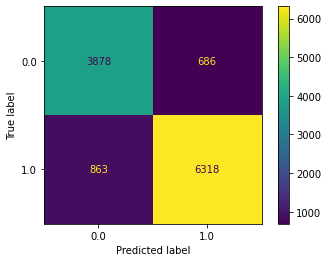

In [85]:
plot_confusion_matrix(log_model_2,X_test_scaled,y_test);

### XGBoost 

[0]	train-logloss:0.636735
[10]	train-logloss:0.375797
[20]	train-logloss:0.300048
[30]	train-logloss:0.27002
[40]	train-logloss:0.256032
[50]	train-logloss:0.247573
[60]	train-logloss:0.241036
[70]	train-logloss:0.235343
[79]	train-logloss:0.231159


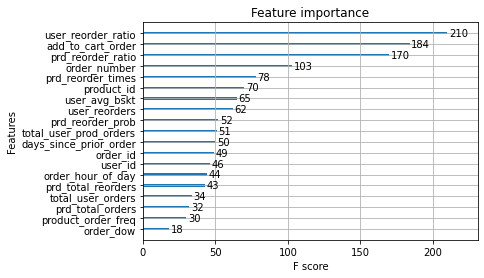

In [64]:
# Instantiate and train model to understand feature importance 

d_train = xgb.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
watchlist= [(d_train, "train")]
bst = xgb.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgb.plot_importance(bst);

## Market Basket Analysis - Apriori
__________________________________________________________________________________________________________________

### Advantages of Market Basket Analysis
There are many advantages to implementing Market Basket Analysis in marketing. Market basket Analysis(MBA) can be applied to data of customers from the point of sale (PoS) systems.

It helps retailers with:

- Increases customer engagement
- Boosting sales and increasing RoI
- Improving customer experience
- Optimize marketing strategies and campaigns
- Help to understand customers better
- Identifies customer behavior and pattern

I will be using this analysis to identify frequent item sets using association rules. In doing so I will be able to identify commonly bought together products to help Instacart understand their key basket builders to influence merchandising and promotional strategies.

### Step 1: Data Integration

In [65]:
# Combining dataframes 

data = orders_prior.merge(products, on = 'product_id')

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396559 entries, 0 to 396558
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_id           396559 non-null  int64  
 1   product_id         396559 non-null  float64
 2   add_to_cart_order  396559 non-null  float64
 3   reordered          396559 non-null  float64
 4   product_name       396559 non-null  object 
 5   aisle_id           396559 non-null  int64  
 6   department_id      396559 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 24.2+ MB


In [67]:
# Checking for nulls 

data.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
product_name         0
aisle_id             0
department_id        0
dtype: int64

### Step 2: Basket Creation

In [68]:
# Create a frequency table of product_ids

product_counts = data.groupby('product_id')['order_id'].count().reset_index().rename(columns = {'order_id'\
                                                                                                    :'frequency'})

product_counts = product_counts.sort_values('frequency', ascending=False)[0:100].reset_index(drop=True)

product_counts.head(10)

,product_id,frequency
0,24852.0,5874
1,13176.0,4718
2,21137.0,3188
3,21903.0,2979
4,47209.0,2625
5,47766.0,2144
6,47626.0,1839
7,16797.0,1803
8,27966.0,1757
9,26209.0,1650


In [69]:
freq_products = list(product_counts.product_id)
freq_products[1:10]

[13176.0,
 21137.0,
 21903.0,
 47209.0,
 47766.0,
 47626.0,
 16797.0,
 27966.0,
 26209.0]

In [70]:
order_products = data[data.product_id.isin(freq_products)]
order_products.shape

(91592, 7)

In [71]:
basket = order_products.pivot_table(columns='product_name', values='reordered', \
                                    index='order_id').reset_index().fillna(0).set_index('order_id')

In [72]:
basket.head()

product_name,100% Raw Coconut Water,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Bartlett Pears,Blueberries,Boneless Skinless Chicken Breasts,...,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Whole Milk,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [73]:
# Creating encoder 

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
basket = basket.applymap(encode_units)
basket.head()

product_name,100% Raw Coconut Water,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Bartlett Pears,Blueberries,Boneless Skinless Chicken Breasts,...,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Whole Milk,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Step 3: Apply Apriori Algorithm

In [74]:
# Only looking at first 100K due to memory constraints

basket_subset = basket[:100000]

In [78]:
# Frequency with support 

frequent_items = apriori(basket_subset, min_support=0.01, use_colnames=True)

frequent_items.head()

,support,itemsets
0,0.012287,(100% Raw Coconut Water)
1,0.019444,(100% Whole Wheat Bread)
2,0.012427,(2% Reduced Fat Milk)
3,0.028485,(Apple Honeycrisp Organic)
4,0.016686,(Asparagus)


In [79]:
# Getting Association rules - Lift

rules = association_rules(frequent_items, metric='lift', min_threshold=1)

rules.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
29,(Organic Raspberries),(Organic Strawberries),0.046288,0.085663,0.010542,0.227753,2.658692,0.006577,1.183994
28,(Organic Strawberries),(Organic Raspberries),0.085663,0.046288,0.010542,0.123064,2.658692,0.006577,1.087551
5,(Organic Raspberries),(Bag of Organic Bananas),0.046288,0.137048,0.014522,0.313725,2.289173,0.008178,1.257445
4,(Bag of Organic Bananas),(Organic Raspberries),0.137048,0.046288,0.014522,0.105960,2.289173,0.008178,1.066745
14,(Banana),(Organic Fuji Apple),0.172339,0.027856,0.010402,0.060361,2.166853,0.005602,1.034592
15,(Organic Fuji Apple),(Banana),0.027856,0.172339,0.010402,0.373434,2.166853,0.005602,1.320947
2,(Bag of Organic Bananas),(Organic Hass Avocado),0.137048,0.072503,0.021189,0.154610,2.132461,0.011253,1.097123
3,(Organic Hass Avocado),(Bag of Organic Bananas),0.072503,0.137048,0.021189,0.292248,2.132461,0.011253,1.219287
26,(Organic Strawberries),(Organic Hass Avocado),0.085663,0.072503,0.013160,0.153627,2.118895,0.006949,1.095848
27,(Organic Hass Avocado),(Organic Strawberries),0.072503,0.085663,0.013160,0.181512,2.118895,0.006949,1.117104


In [80]:
# Getting Association rules - Support

rules = association_rules(frequent_items, metric='support', min_threshold=.015)

rules.sort_values('support', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(Bag of Organic Bananas),(Organic Hass Avocado),0.137048,0.072503,0.021189,0.154610,2.132461,0.011253,1.097123
3,(Organic Hass Avocado),(Bag of Organic Bananas),0.072503,0.137048,0.021189,0.292248,2.132461,0.011253,1.219287
4,(Organic Strawberries),(Bag of Organic Bananas),0.085663,0.137048,0.019793,0.231051,1.685922,0.008053,1.122250
5,(Bag of Organic Bananas),(Organic Strawberries),0.137048,0.085663,0.019793,0.144422,1.685922,0.008053,1.068677
10,(Organic Strawberries),(Banana),0.085663,0.172339,0.018641,0.217604,1.262649,0.003878,1.057854
11,(Banana),(Organic Strawberries),0.172339,0.085663,0.018641,0.108163,1.262649,0.003878,1.025228
6,(Organic Avocado),(Banana),0.057737,0.172339,0.017559,0.304111,1.764609,0.007608,1.189358
7,(Banana),(Organic Avocado),0.172339,0.057737,0.017559,0.101884,1.764609,0.007608,1.049154
8,(Organic Baby Spinach),(Banana),0.080916,0.172339,0.017489,0.216135,1.254124,0.003544,1.055871
9,(Banana),(Organic Baby Spinach),0.172339,0.080916,0.017489,0.101479,1.254124,0.003544,1.022885


In [81]:
# Getting Association rules - Confidence 

rules = association_rules(frequent_items, metric='confidence', min_threshold=.2)

rules.sort_values('confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7,(Organic Fuji Apple),(Banana),0.027856,0.172339,0.010402,0.373434,2.166853,0.005602,1.320947
2,(Organic Raspberries),(Bag of Organic Bananas),0.046288,0.137048,0.014522,0.313725,2.289173,0.008178,1.257445
5,(Organic Avocado),(Banana),0.057737,0.172339,0.017559,0.304111,1.764609,0.007608,1.189358
1,(Organic Hass Avocado),(Bag of Organic Bananas),0.072503,0.137048,0.021189,0.292248,2.132461,0.011253,1.219287
10,(Strawberries),(Banana),0.044123,0.172339,0.012881,0.291930,1.693929,0.005277,1.168898
4,(Large Lemon),(Banana),0.043809,0.172339,0.011310,0.258167,1.498019,0.003760,1.115697
3,(Organic Strawberries),(Bag of Organic Bananas),0.085663,0.137048,0.019793,0.231051,1.685922,0.008053,1.122250
11,(Organic Raspberries),(Organic Strawberries),0.046288,0.085663,0.010542,0.227753,2.658692,0.006577,1.183994
9,(Organic Whole Milk),(Banana),0.048207,0.172339,0.010682,0.221579,1.285712,0.002374,1.063255
8,(Organic Strawberries),(Banana),0.085663,0.172339,0.018641,0.217604,1.262649,0.003878,1.057854


**Observation:**
- Unsuprisingly produce, and specifically bananas, are in most of the top item sets


## Model Results
__________________________________________________________________________________________________________________
#### Logistic Regression:
- The best model I ran had 90% Precision and 88% Recall scores. 

![Confusion Matrix](./images/confusion_matrix.png)

#### XGBoost:
- Using XGBoost, I was able to identify the most important features in prediciting customer reorders. In older notebooks, I fit the model onto the train data, but was not getting results better than the LogReg model. The top three important features for this model were:
   1. user_reorder_ratio
   2. add_to_cart_order
   3. prd_reorder_ratio
   
#### Apriori:
- The Apriori Algorithm analysis was successful in identifying frequent item sets. Some observations:
   - Produce and/or Dairy items are included in all of the top item sets
   - Banana's are the number one basket builder for customers 
   - Top Item Combinations by Association Rule:
       - **Lift:** Organic Raspberries & Organic Strawberries
       - **Support:** Bag of Organic Bananas & Organic Haas Avocados
       - **Confidence:** Organic Fuji Apple & Banana

## Recommendations
__________________________________________________________________________________________________________________
From this analysis I have generated the following recommendations that Instacart can utilize:

1. **Banana's are important.** Since Bananas are the number one basket building item, offering promotions on these products is a good way to get people in the door<br><br>

2. **Merchandising:** Using the reorder prediction model and frequent item sets, Instacart can better inform  merchandising decisions to answer questions like, What 'aisles' or products should be displayed near each other? Understanding the answer to questions like these are important in targeting merchandising placements & display ads to individual users could help Instacart maximize each user's basket. <br><br>

3. **Recommendations**: Understanding what a customer is going to order in the future is important for product recommendations. Using the predictive LogReg model, Instacart can optimize recommendation widgets like 'Add to Cart' with the likely items that customer will order. <br><br>

4. **Promotional Strategy:** Online grocers are in a unique position to cross merchandise products that wouldn't normally live together in a traditional grocery store, for example, ice cream and hot dogs for the Fourth of July. Using the Apriori results, Instacart can understand what items are commonly (or uncommonly) ordered together in order to implement targeted promotions to customers. 
    

## Future Steps
__________________________________________________________________________________________________________________

There are a number of steps I would like to take in the future to improve results of this analysis. These include the following:

1. **Display Ad Opportunity Cost** - With additional data regarding average product costs and average sales price, this analysis can be updated to identify the opportunity cost of showing one product to a customer over another. For example, if we know that Customer X orders Corn Flakes every week, we can use the model to identify frequently bundled items and display the item to Customer X that generates the most profit for Instacart while also keeping the customer happy <br><br>
2. **Datetime Considerations** - While this analysis largely focused on user behavior as it pertained to order history and products, implementing additional features around when a user orders certain items, how often customers are making "stock up" baskets versus "everyday" baskets and more could improve the overall results of the model. <br><br>
3. **Reviews & Ratings** - With more data around product reviews and ratings on a customer level, I would like to implement a Collaborative Item-Based Filtering recommender system to see how it compares to the binary classificaiton model implemented in this notebook. 